In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

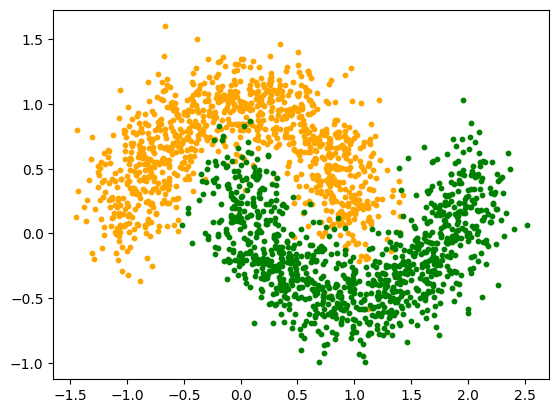

In [3]:
plt.scatter(X[y==0, 0], X[y==0, 1], color='orange', s=10)
plt.scatter(X[y==1, 0], X[y==1, 1], color='green', s=10)

In [4]:
class lin_layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
        self.biases = np.zeros((1, n_neurons))
        self.inputs = None
        self.dweights = None
        self.dbiases = None

    def forward(self, inputs, is_training=True):
        self.inputs = np.array(inputs)
        return np.dot(self.inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        return np.dot(dvalues, self.weights.T)

In [5]:
class Sigmoid_activation:
    def __init__(self):
        self.output = None
        self.dinputs = None

    def forward(self, inputs, is_training=True):
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
        return self.dinputs

In [6]:
class ReLu_activation:
    def __init__(self):
        self.output = None
        self.dinputs = None
        self.inputs = None

    def forward(self, inputs, is_training=True):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

In [7]:
class Softmax_activation:
    def __init__(self):
        self.output = None

    def forward(self, inputs, is_training=True):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        return self.output

    def backward(self, dvalues):
        raise NotImplementedError

In [8]:
class Softmax_CCE:
    def __init__(self):
        self.output = None
        self.dinputs = None

    def forward(self, inputs, y_true):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

        samples = len(inputs)
        clipped = np.clip(probabilities, 1e-7, 1 - 1e-7)
        correct_confidences = clipped[range(samples), y_true]
        loss = np.mean(-np.log(correct_confidences))
        return loss

    def backward(self, y_true):
        samples = len(self.output)
        self.dinputs = self.output.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples
        return self.dinputs


In [9]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m = []
        self.v = []

    def setup(self, layers):
        self.m = []
        self.v = []
        for layer in layers:
            self.m.append({
                "w": np.zeros_like(layer.weights),
                "b": np.zeros_like(layer.biases)
            })
            self.v.append({
                "w": np.zeros_like(layer.weights),
                "b": np.zeros_like(layer.biases)
            })

    def step(self):
        self.t += 1

    def update(self, layer, dweights, dbiases, idx):
        m = self.m[idx]
        v = self.v[idx]

        m["w"] = self.beta1 * m["w"] + (1 - self.beta1) * dweights
        m["b"] = self.beta1 * m["b"] + (1 - self.beta1) * dbiases
        v["w"] = self.beta2 * v["w"] + (1 - self.beta2) * (dweights ** 2)
        v["b"] = self.beta2 * v["b"] + (1 - self.beta2) * (dbiases ** 2)

        m_w_corr = m["w"] / (1 - self.beta1 ** self.t)
        m_b_corr = m["b"] / (1 - self.beta1 ** self.t)
        v_w_corr = v["w"] / (1 - self.beta2 ** self.t)
        v_b_corr = v["b"] / (1 - self.beta2 ** self.t)

        layer.weights -= self.lr * m_w_corr / (np.sqrt(v_w_corr) + self.epsilon)
        layer.biases -= self.lr * m_b_corr / (np.sqrt(v_b_corr) + self.epsilon)

In [10]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate
        self.binary_mask = None

    def forward(self, inputs, is_training=True):
        if is_training:
            self.binary_mask = np.random.binomial(1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            return inputs * self.binary_mask
        self.binary_mask = None
        return inputs

    def backward(self, dvalues):
        if self.binary_mask is None:
            return dvalues
        return dvalues * self.binary_mask

In [11]:
class BatchNorm1D:
    def __init__(self, n_features, momentum=0.9, eps=1e-5):
        self.eps = eps
        self.momentum = momentum

        self.gamma = np.ones((1, n_features))
        self.beta = np.zeros((1, n_features))

        self.running_mean = np.zeros((1, n_features))
        self.running_var = np.ones((1, n_features))
        self.dgamma = None
        self.dbeta = None

    def forward(self, X, training=True):
        self.X = X

        if training:
            self.batch_mean = X.mean(axis=0, keepdims=True)
            self.batch_var = X.var(axis=0, keepdims=True)
            self.X_norm = (X - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
            self.running_mean = (
                self.momentum * self.running_mean
                + (1 - self.momentum) * self.batch_mean
            )
            self.running_var = (
                self.momentum * self.running_var
                + (1 - self.momentum) * self.batch_var
            )

        else:
            self.X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.eps)

        out = self.gamma * self.X_norm + self.beta
        return out

    def backward(self, d_out):
        m = self.X.shape[0]
        self.dgamma = np.sum(d_out * self.X_norm, axis=0, keepdims=True)
        self.dbeta = np.sum(d_out, axis=0, keepdims=True)
        dX_norm = d_out * self.gamma

        dvar = np.sum(
            dX_norm * (self.X - self.batch_mean) * -0.5 / (self.batch_var + self.eps) ** 1.5,
            axis=0, keepdims=True
        )
        dmean = np.sum(
            dX_norm * -1 / np.sqrt(self.batch_var + self.eps),
            axis=0, keepdims=True
        ) + dvar * np.mean(-2 * (self.X - self.batch_mean), axis=0, keepdims=True)

        dX = (
            dX_norm / np.sqrt(self.batch_var + self.eps)
            + dvar * 2 * (self.X - self.batch_mean) / m
            + dmean / m
        )

        return dX


In [12]:
class Net:
    def __init__(self, layers: list, epoch=5, lr=0.01, batch_size=32, optimizer=Adam, verbose=1):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.batch_size = batch_size
        self.verbose = verbose

        self.trainable_layers = [layer for layer in self.layers if hasattr(layer, "weights")]

        self.optimizer = optimizer(lr)
        self.optimizer.setup(self.trainable_layers)

        self.loss_activation = Softmax_CCE()

    def forward(self, inputs, is_training=True):
        x = np.array(inputs, dtype=float)
        for layer in self.layers:
            try:
                x = layer.forward(x, is_training)
            except TypeError:
                x = layer.forward(x)
        return x

    def backward(self, dvalues):
        trainable_idx = len(self.trainable_layers) - 1

        for layer in reversed(self.layers):
            dvalues = layer.backward(dvalues)

            if hasattr(layer, "weights"):
                self.optimizer.update(layer, layer.dweights, layer.dbiases, trainable_idx)
                trainable_idx -= 1

    def fit(self, X, y):
        X, y = np.array(X, dtype=float), np.array(y, dtype=int)
        loss_progress = []

        for epoch in range(self.epoch):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y[indices]

            for start in range(0, len(X_shuffled), self.batch_size):
                end = start + self.batch_size
                xb, yb = X_shuffled[start:end], y_shuffled[start:end]

                if hasattr(self.optimizer, "step"):
                    self.optimizer.step()

                outputs = self.forward(xb, is_training=True)
                loss = self.loss_activation.forward(outputs, yb)
                dvalues = self.loss_activation.backward(yb)
                self.backward(dvalues)

            outputs_full = self.forward(X, is_training=False)
            epoch_loss = self.loss_activation.forward(outputs_full, y)
            loss_progress.append(epoch_loss)
            if epoch % self.verbose == 0:
              print(f"Epoch {epoch+1}/{self.epoch} | Loss: {epoch_loss:.6f}")

        return loss_progress

    def predict_proba(self, inputs):
        outputs = self.forward(inputs, is_training=False)
        exp_values = np.exp(outputs - np.max(outputs, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def predict(self, inputs):
        return np.argmax(self.predict_proba(inputs), axis=1)

In [13]:
layers = [
    lin_layer(2, 64),
    ReLu_activation(),
    lin_layer(64, 64),
    ReLu_activation(),
    lin_layer(64, 32),
    ReLu_activation(),
    lin_layer(32, 16),
    ReLu_activation(),
    lin_layer(16, 8),
    ReLu_activation(),
    lin_layer(8, 2)
]
nn = Net(layers, epoch=130, lr=0.005, optimizer=Adam, verbose=50)
history = nn.fit(X_train, y_train)



Epoch 1/130 | Loss: 0.221305
Epoch 51/130 | Loss: 0.077573
Epoch 101/130 | Loss: 0.060314


In [14]:
def plot_decision_boundary(nn, X, y, h=0.01):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = nn.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlGn)
    plt.scatter(X[y==0, 0], X[y==0, 1], color='orange', s=10, label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], color='green', s=10, label='Class 1')
    plt.legend()
    plt.title("Decision boundary")
    plt.show()
def plot_history(history):
    plt.plot(history)
    plt.title("Loss progress")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

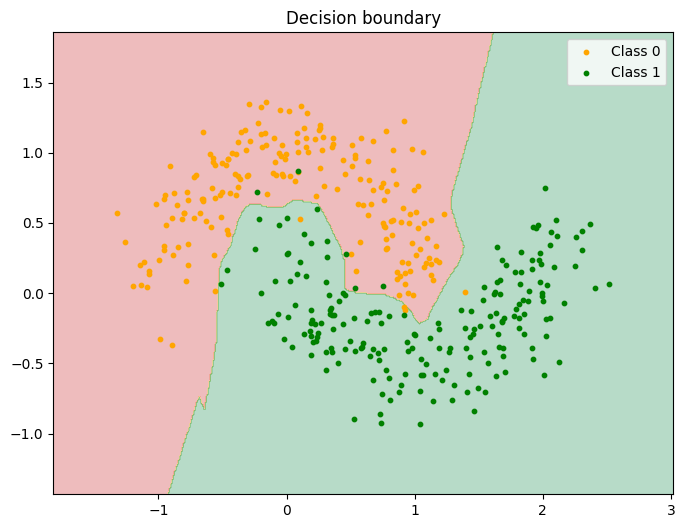

In [15]:
plot_decision_boundary(nn, X_test, y_test)

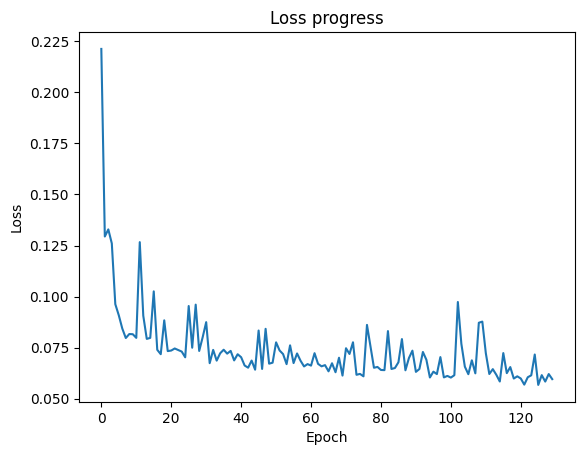

In [16]:
plot_history(history)

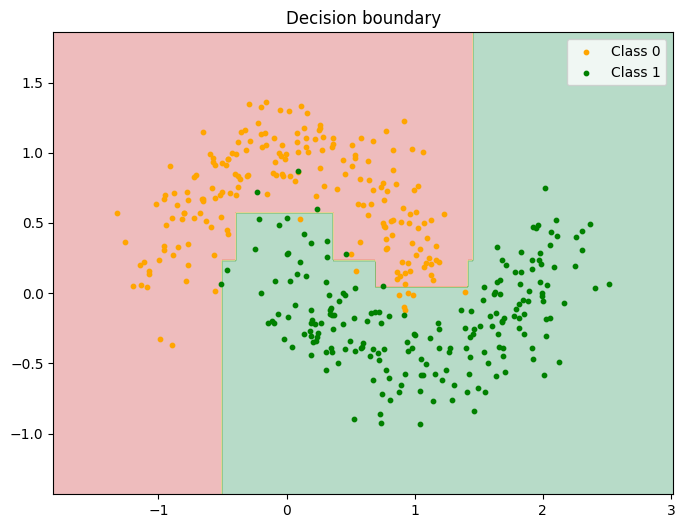

In [17]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
plot_decision_boundary(dt, X_test, y_test)

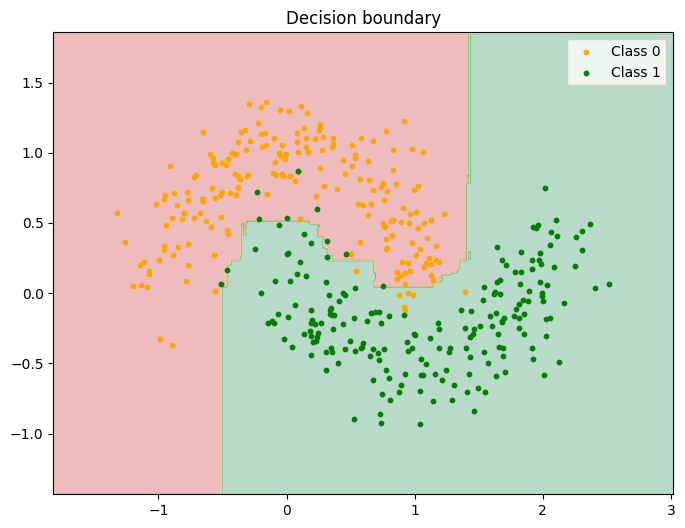

In [18]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X_test, y_test)

In [19]:
# mnist importing
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
mnist = fetch_openml('mnist_784', version=1)


In [20]:
X, y = mnist["data"], mnist["target"].astype(int)
X /= 255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
layers = [
    lin_layer(784, 512),
    BatchNorm1D(512),
    ReLu_activation(),
    Dropout(rate=0.2),

    lin_layer(512, 128),
    BatchNorm1D(128),
    ReLu_activation(),
    Dropout(rate=0.2),

    lin_layer(128, 32),
    BatchNorm1D(32),
    ReLu_activation(),
    Dropout(rate=0.2),

    lin_layer(32, 10)
]

In [22]:
nn = Net(layers, epoch=25, lr=0.0015, batch_size=128)
history = nn.fit(X_train, y_train)

Epoch 1/25 | Loss: 0.121824
Epoch 2/25 | Loss: 0.069525
Epoch 3/25 | Loss: 0.050110
Epoch 4/25 | Loss: 0.040659
Epoch 5/25 | Loss: 0.033185
Epoch 6/25 | Loss: 0.027668
Epoch 7/25 | Loss: 0.030747
Epoch 8/25 | Loss: 0.019330
Epoch 9/25 | Loss: 0.015863
Epoch 10/25 | Loss: 0.018114
Epoch 11/25 | Loss: 0.013408
Epoch 12/25 | Loss: 0.014706
Epoch 13/25 | Loss: 0.011594
Epoch 14/25 | Loss: 0.010630
Epoch 15/25 | Loss: 0.009680
Epoch 16/25 | Loss: 0.007176
Epoch 17/25 | Loss: 0.006349
Epoch 18/25 | Loss: 0.008684
Epoch 19/25 | Loss: 0.005418
Epoch 20/25 | Loss: 0.004902
Epoch 21/25 | Loss: 0.005554
Epoch 22/25 | Loss: 0.005305
Epoch 23/25 | Loss: 0.005459
Epoch 24/25 | Loss: 0.004676
Epoch 25/25 | Loss: 0.004533


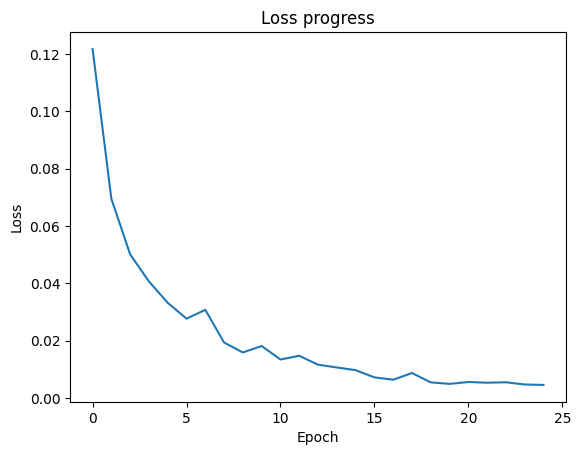

In [23]:
plot_history(history)

In [24]:
print(accuracy_score(y_test, nn.predict(X_test)))

0.9838571428571429


In [25]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train, y_train)
print(accuracy_score(y_test, rf.predict(X_test)))

0.8547857142857143


In [26]:
layers = [
    lin_layer(784, 512),
    ReLu_activation(),
    lin_layer(512, 256),
    ReLu_activation(),
    lin_layer(256, 64),
    ReLu_activation(),
    lin_layer(64, 10)
]

In [27]:
nn = Net(layers, epoch=25, lr=0.0008, batch_size=64)
history = nn.fit(X_train, y_train)

Epoch 1/25 | Loss: 0.080365
Epoch 2/25 | Loss: 0.063421
Epoch 3/25 | Loss: 0.036600
Epoch 4/25 | Loss: 0.034489
Epoch 5/25 | Loss: 0.019123
Epoch 6/25 | Loss: 0.021381
Epoch 7/25 | Loss: 0.025886
Epoch 8/25 | Loss: 0.021208
Epoch 9/25 | Loss: 0.014970
Epoch 10/25 | Loss: 0.018529
Epoch 11/25 | Loss: 0.030599
Epoch 12/25 | Loss: 0.010907
Epoch 13/25 | Loss: 0.010762
Epoch 14/25 | Loss: 0.015351
Epoch 15/25 | Loss: 0.010281
Epoch 16/25 | Loss: 0.003454
Epoch 17/25 | Loss: 0.011351
Epoch 18/25 | Loss: 0.022681
Epoch 19/25 | Loss: 0.003935
Epoch 20/25 | Loss: 0.009161
Epoch 21/25 | Loss: 0.005413
Epoch 22/25 | Loss: 0.004599
Epoch 23/25 | Loss: 0.006809
Epoch 24/25 | Loss: 0.003002
Epoch 25/25 | Loss: 0.002666


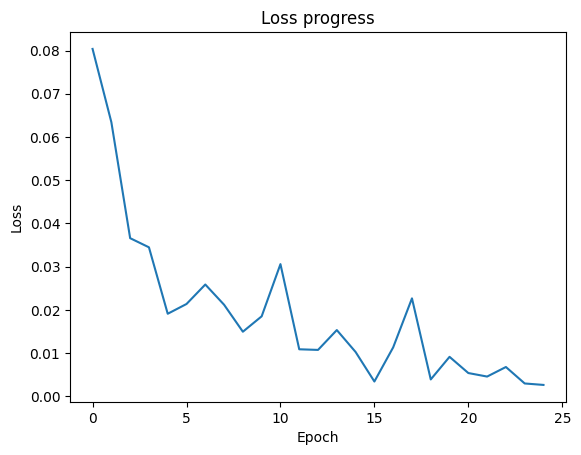

In [28]:
plot_history(history)

In [29]:
print(accuracy_score(y_test, nn.predict(X_test)))

0.9829285714285714
